<a href="https://colab.research.google.com/github/ryanleeallred/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this  blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).




In [48]:
# 1  #implement bayes in python function 

def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):
    return true_positive_rate * prob_drunk_prior / (prob_drunk_prior * true_positive_rate + false_positive_rate*(1-prob_drunk_prior))

r = prob_drunk_given_positive(0.001, .08 , 1)
r

0.012357884330202669

In [49]:
# answer the questions
prob_drunk_prior = 0.001   # P(drunk) #P(sober) = .999
false_positive_rate =  0.08  # P(pos | not drunk)
true_positive_rate = 1    # this is P(pos | drunk)  

result1 = prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate)

# "What is the probability that a person is drunk after one positive breathalyzer test?: "
print(result1)

# What is the probability that a person is drunk after two positive breathalyzer tests?
result2 = prob_drunk_given_positive(result1, false_positive_rate, true_positive_rate) #given that we tested + once we 
                                #    ^^^^^^^ we sub the resulting P(drunk) after 1 test as the prior prob 
print("probability that a person is drunk after two positive breathalyzer tests: ", result2)
result3 = prob_drunk_given_positive(result2, false_positive_rate, true_positive_rate)
print("...after THREE: ", result3)
print(result3," <= wow!, busted.. moral of the story: \n \t \t\t if you take a breathalizer and test positive 1x stop while you're ahead \n\t \t\t  and you can then argue about the value of prior in court!")

# How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?
  # 3 positive tests are sufficient


def drunk_ntests(pr, fp, tp, numtests): #function runs n tests and return probability of drunk given prior results
    prior  = pr #setup
    i = 1 
    while i <= numtests:
         prior = prob_drunk_given_positive(prior, false_positive_rate, true_positive_rate)
         i += 1
    return (prior, numtests)

confidence = 0.95

# use the prev function to keep running tests until we hit a target probability 
def findntest(targetc):
    targetc = confidence
    i = 1
    p, numtests = drunk_ntests(0.001, 0.08, 1, i)    #run 1x and check
    while p <= (targetc):
        i += 1
        p, numtests = drunk_ntests(0.001, 0.08, 1, i)
        print(p, numtests, i)
    print('\n\n', numtests, ' tests are sufficient to obtain the probability youre drunk is ', targetc, '\n P(drunk)= ', p)
    
findntest(0.85)

0.012357884330202669
probability that a person is drunk after two positive breathalyzer tests:  0.13525210993291495
...after THREE:  0.6615996951348605
0.6615996951348605  <= wow!, busted.. moral of the story: 
 	 		 if you take a breathalizer and test positive 1x stop while you're ahead 
	 		  and you can then argue about the value of prior in court!
0.13525210993291495 2 2
0.6615996951348605 3 3
0.9606895076105054 4 4


 4  tests are sufficient to obtain the probability youre drunk is  0.95 
 P(drunk)=  0.9606895076105054


In [50]:
#this came up, i'm not 100% sure i have a generalized understanding of the application... see below
#whats the prob that you are drunk after testing positive and then negative IF the test is only 99.9% accurate
fail1 = prob_drunk_given_positive(prob_drunk_prior ,false_positive_rate, .999)
fail2 =  ((1-0.999)* fail1) / .001                 # not sure about this..yeah it was jacked up due to an error in
fail2  #still not sure about this, but dont have ti

0.012345679012345692

(1599, 12)
red  (2.469646316555691, 2.53880550343965, 2.607964690323609)
white  (6.249335746564006, 6.391414863209474, 6.533493979854942)
Mean(statistic=6.391414863209474, minmax=(6.249385364278425, 6.533444362140522))


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xticks'

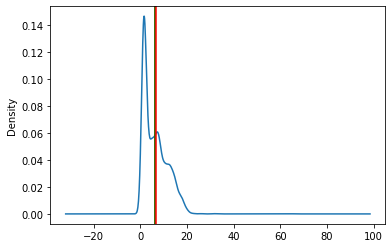

In [84]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data= []
dfw = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=';')

dfr = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delimiter=';')
print (dfr.shape)

dfr['residual sugar'].mean()
dfw['residual sugar'].mean()

def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  # pass extra parameter (ddof=1) to calculate **sample** standard deviation
  s = data.std(ddof=1)
  stderr = s / np.sqrt(n)
  # Lookup the t-statistic that corresponds to 95% area under the curve
  # for my given degrees of freedom: 49
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  margin_of_error = t*stderr
  return (mean - margin_of_error, mean, mean + margin_of_error)

frqw = confidence_interval(dfw['residual sugar'])
frqw
frqr = confidence_interval(dfr['residual sugar'])
print ('red ', frqr)
print('white ', frqw)
#st.bayes_mvs(data, alpha=0.9)
bayesian, _, _ = stats.bayes_mvs(dfw['residual sugar'], alpha=.95)
print(bayesian)

##confidence int
dfw['residual sugar'].plot.density()
#dfr['residual sugar'].plot.density()  #red 

plt.axvline(frqw[0], color='red')
plt.axvline(frqw[1], color='green')
plt.axvline(frqw[2], color='red')
plt.show()
##TODO fix x axis

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

Frequentist statistics deals with the frequency of occurrence of specific results, comparing sample data to a concept of a population--allowing us to infer from the sample to the larger population. 

Bayesian statistics frames the question differently, allowing us to talk about the probability that we obtain a result or the hypothesis is true. Bayesian statistics incorporates the notion of prior probabilities or beliefs, allowing one to account for previous results in the calculation.

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!